# EMT Metabolism Model — Equations (1–31)

This notebook implements the ROS/AMPK/HIF-1 ODEs (eqs. 1–5), the algebraic metabolic fluxes (eqs. 6–22), and the ATP bookkeeping (eqs. 23–31). It mirrors the MATLAB structure published in here: https://doi.org/10.1038/s41540-025-00525-x

 

**Contents**
1. Shifted Hill & competitive combiner
2. Default parameters
3. Flux equations (algebraic) and solver
4. ODEs for A, H, mtROS, noxROS
5. Simulation helper
6. Example run + plots


In [15]:
#installation
#Use emt_metabolism (Python 3.10.19)
!pip install -r requirements.txt


In [16]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

## 1) Shifted Hill and competitive combiner

In [17]:
def Hs(x, x0, n, lam):
    """Shifted Hill function (direct port of MATLAB Hillshift).
    lam in (0, inf), n>0; approaches lam for x >> x0, approaches 1 for x << x0.
    Formula: lam + (1-lam)/(1+(x/x0)^n)
    """
    return lam + (1.0 - lam) * 1.0/(1.0 + (x/x0)**n)

def Hcomp(g0, gH, gA, H, H0, nH, A, A0, nA):
    """Competitive combiner for noxROS numerator.
    (g0 + gH*(H/H0)^nH + gA*(A/A0)^nA) / (1 + (H/H0)^nH + (A/A0)^nA)
    """
    HH = (H/H0)**nH if H0>0 else 0.0
    AA = (A/A0)**nA if A0>0 else 0.0
    return (g0 + gH*HH + gA*AA) / (1.0 + HH + AA)

## 2) Default parameters

In [18]:
def default_params():
    p = dict(
        # mtROS (eq.1)
        gr=0.9, gama1=50.0, gamaf=50.0*(9/2), gQ1=10.0, kr=5.0,
        Ar0_n=350.0, nar_n=2.0, Lamda_ar_n=2.0,
        Q2R0=10.0, nQ2R=2.0, Lamda_Q2R=1.2,
        # noxROS (eq.2)
        g0=1.0, g1=5.0, g2=0.2, gr_nox=40.0, kr_nox=5.0,
        hr0_nox=250.0, nhr_nox=2.0, Ar0_nox=150.0, nar_nox=2.0,
        # AMPK (eq.4)
        ga=40.0, ka=0.2, Ra0=250.0, nra=4.0, Lamda_ra=8.0,
        ha0=150.0, nha=1.0, Lamda_ha=0.1,
        Aa0=2000.0, naa=2.0, Lamda_aa=0.25,
        # HIF-1 (eq.5)
        gh=15.0, kh=0.3, Ah0=150.0, nah=1.0, Lamda_ah=0.1,
        Rh0=40.0, nrh=4.0, Lamda_rh=0.2,
        G2h0=250.0, nG2h=4.0, Lamda_G2h=0.1,
        M=1200.0, Mh0=150.0, nMh=2.0, Lamda_Mh=0.8,
        # Uptakes & capacities (eqs. 6–8)
        g00=20.0, c00=15.0, q00=10.0, gF00=5.0,
        hg0=150.0, nhg=4.0, lamda_hg=6.0,
        Ag0=200.0, nag=2.0, lamda_ag=4.0,
        Ac0=250.0, nac=4.0, lamda_ac=8.0,
        AF00=200.0, nAF00=2.0, lamda_AF00=4.0,
        # Flux base caps & Hill params (eqs. 9–22)
        g1_base=100.0, g2_base=150.0, f0=3.0,
        hg2=200.0, nhg2=4.0, lamda_hg2=8.0,
        ngg1=2.0, lamda_gg1=0.1,
        ncg1=4.0, lamda_cg1=0.1,
        ngg2=2.0, lamda_gg2=0.1,
        Af0=200.0, naf=4.0, lamda_af=6.0,
        hf0=200.0, nhf=4.0, lamda_hf=0.8,
        nF00f1=2.0, lamda_F00f1=0.8,
        nF00f2=2.0, lamda_F00f2=0.1,
        hf20=200.0, nhf2=2.0, lamda_hf2=4.0,
        hq0=350.0, nhq=4.0, lamda_hq=0.2,
        nqq1=2.0, lamda_qq1=0.5,
        nqq3=2.0, lamda_qq3=0.5,
        q1=30.0, q3=20.0,
        hq30=200.0, nhq3=4.0, lamda_hq3=2.0,
        Aq30=200.0, naq3=2.0, lamda_aq3=0.5,
        ngg3=2.0, lamda_gg3=0.1, g3=60.0,
        Ag30=200.0, nag3=2.0, lamda_ag3=0.25,
        Mg30=150.0, nMg3=2.0, lamda_Mg3=2.0,
        gf2=75.0,
        nqq2=2.0, lamda_qq2=0.5,
        Aq20=250.0, nAq2=4.0, lamda_Aq2=5.0,
        Mq20=150.0, nMq2=2.0, lamda_Mq2=0.9,
        Mg0=150.0, nMg=2.0, lamda_Mg=2.0,
        Mq0=150.0, nMq=2.0, lamda_Mq=2.0,
        Mq10=150.0, nMq1=2.0, lamda_Mq1=2.0,
        Mq30=150.0, nMq3=2.0, lamda_Mq3=2.0,
        g3f=0.1, q3f=0.1,
        # ATP (eqs. 23–31)
        ATP_G1=29.0, ATP_G2=2.0, ATP_F=106.0, ATP_Q1=24.0,
        ATP_Q3=-15.0, ATP_G3=-13.0, ATP_F2=-7.0, ATP_Q2=-2.0,
    )
    return p

## 3) Flux equations (algebraic) and solver

In [19]:
def flux_root_system(x, A, H, p):
    G1,G2,F,Q1,Q3,G3,F2,Q2 = x
    M = p['M']
    # Uptakes & capacities (eqs. 6–8)
    G0 = p['g00']*Hs(H, p['hg0'], p['nhg'], p['lamda_hg']) \
       + p['g00']*Hs(A, p['Ag0'], p['nag'], p['lamda_ag']) \
       + 0.0*p['g00']*Hs(M, p['Mg0'], p['nMg'], p['lamda_Mg'])
    C0 = p['c00']*Hs(A, p['Ac0'], p['nac'], p['lamda_ac'])
    Q0 = p['q00']*Hs(M, p['Mq0'], p['nMq'], p['lamda_Mq'])
    F00= p['gF00']*Hs(A, p['AF00'], p['nAF00'], p['lamda_AF00'])
    # Pools
    G_total = G1+G2+G3
    FA_pool = F + F2 - p['g3f']*G3 - p['q3f']*Q3
    f = np.zeros(8)
    # Eq. 9–14: G1, G2
    f[0] = G1 - p['g1_base']*Hs(G_total, G0, p['ngg1'], p['lamda_gg1']) * Hs(2*G1 + 9*F, C0, p['ncg1'], p['lamda_cg1'])
    f[1] = G2 - p['g2_base']*Hs(H, p['hg2'], p['nhg2'], p['lamda_hg2']) * Hs(G_total, G0, p['ngg2'], p['lamda_gg2'])
    # Eq. 15–18: F (FAO)
    f[2] = F - p['f0']*Hs(H, p['hf0'], p['nhf'], p['lamda_hf']) * \
                   Hs(FA_pool, F00, p['nF00f1'], p['lamda_F00f1']) * \
                   Hs(A, p['Af0'], p['naf'], p['lamda_af']) * \
                   Hs(2*G1 + 9*F, C0, 2.0, 0.1)
    # Eq. 19–22: Q1, Q3, G3, F2, Q2
    f[3] = Q1 - p['q1']*Hs(H, p['hq0'], p['nhq'], p['lamda_hq']) * \
                   Hs(Q1+Q3+Q2, Q0, p['nqq1'], p['lamda_qq1']) * \
                   Hs(M, p['Mq10'], p['nMq1'], p['lamda_Mq1'])
    f[4] = Q3 - p['q3']*Hs(Q1+Q3+Q2, Q0, p['nqq3'], p['lamda_qq3']) * \
                   Hs(H, p['hq30'], p['nhq3'], p['lamda_hq3']) * \
                   Hs(A, p['Aq30'], p['naq3'], p['lamda_aq3']) * \
                   Hs(M, p['Mq30'], p['nMq3'], p['lamda_Mq3'])
    f[5] = G3 - p['g3']*Hs(G_total, G0, p['ngg3'], p['lamda_gg3']) * \
                   Hs(A, p['Ag30'], p['nag3'], p['lamda_ag3']) * \
                   Hs(M, p['Mg30'], p['nMg3'], p['lamda_Mg3'])
    f[6] = F2 - p['gf2']*Hs(FA_pool, F00, p['nF00f2'], p['lamda_F00f2']) * \
                   Hs(H, p['hf20'], p['nhf2'], p['lamda_hf2'])
    f[7] = Q2 - 30.0*Hs(Q1+Q3+Q2, Q0, p['nqq2'], p['lamda_qq2']) * \
                   Hs(A, p['Aq20'], p['nAq2'], p['lamda_Aq2']) * \
                   Hs(M, p['Mq20'], p['nMq2'], p['lamda_Mq2'])
    return f

def solve_fluxes(A, H, p, x0=None):
    if x0 is None:
        x0 = np.array([1,1,1,1,1,1,1,1], dtype=float)
    sol = root(lambda v: flux_root_system(v, A, H, p), x0, method='hybr')
    x = sol.x
    pools = dict(
        G_total = x[0]+x[1]+x[5],
        FA_pool = x[2]+x[6]-p['g3f']*x[5]-p['q3f']*x[4],
    )
    return x, pools

## 4) ODEs (A, H, mtROS, noxROS) and ATP bookkeeping

In [20]:
def atp_from_fluxes(x, p):
    G1,G2,F,Q1,Q3,G3,F2,Q2 = x
    return (p['ATP_G1']*G1 + p['ATP_G2']*G2 + p['ATP_F']*F + p['ATP_Q1']*Q1
            + p['ATP_Q3']*Q3 + p['ATP_G3']*G3 + p['ATP_F2']*F2 + p['ATP_Q2']*Q2)

def odes_1_to_31(t, y, p):
    A, H, Rmt, Rnox = y
    x,_ = solve_fluxes(A, H, p)
    G1,G2,F,Q1,Q3,G3,F2,Q2 = x
    RT = Rmt + Rnox
    # Eq. 1 mtROS
    num_mt = p['gama1']*G1 + p['gamaf']*F + p['gQ1']*Q1
    den_mt = p['kr']*(Hs(A, p['Ar0_n'], p['nar_n'], p['Lamda_ar_n']) + 0.1*Hs(Q2, p['Q2R0'], p['nQ2R'], p['Lamda_Q2R']))
    dRmt = p['gr']*num_mt/den_mt - Rmt
    # Eq. 2 noxROS
    prod_nox = (p['gr_nox']/ (p['kr_nox']*Hs(Q2, p['Q2R0'], p['nQ2R'], p['Lamda_Q2R']))) * \
               Hcomp(p['g0'], p['g1'], p['g2'], H, p['hr0_nox'], p['nhr_nox'], A, p['Ar0_nox'], p['nar_nox'])
    dRnox = prod_nox - Rnox
    # Eq. 4 AMPK
    ATP = atp_from_fluxes(x, p)
    dA = p['ga']*Hs(RT, p['Ra0'], p['nra'], p['Lamda_ra']) * \
               Hs(H, p['ha0'], p['nha'], p['Lamda_ha']) * \
               Hs(ATP, p['Aa0'], p['naa'], p['Lamda_aa']) - p['ka']*A
    # Eq. 5 HIF-1
    dH = p['gh']*Hs(A, p['Ah0'], p['nah'], p['Lamda_ah']) - \
         p['kh']*H*Hs(RT, p['Rh0'], p['nrh'], p['Lamda_rh']) * \
                 Hs(G2, p['G2h0'], p['nG2h'], p['Lamda_G2h']) * \
                 Hs(p['M'], p['Mh0'], p['nMh'], p['Lamda_Mh'])
    return [dA, dH, dRmt, dRnox]

## 5) Simulation helper

In [21]:
def simulate(params=None, t_span=(0, 200), y0=None, dense=False):
    p = default_params() if params is None else params.copy()
    if y0 is None:
        y0 = [200.0, 150.0, 50.0, 50.0]  # A, H, Rmt, Rnox
    fun = lambda t, y: odes_1_to_31(t, y, p)
    sol = solve_ivp(fun, t_span, y0, method='RK45', rtol=1e-6, atol=1e-9, dense_output=dense, max_step=0.5)
    ts = sol.t
    Y = sol.y.T
    fluxes = []
    ATPs = []
    for A,H,Rmt,Rnox in Y:
        fx,_ = solve_fluxes(A,H,p)
        fluxes.append(fx)
        ATPs.append(atp_from_fluxes(fx,p))
    fluxes = np.array(fluxes)
    ATPs = np.array(ATPs)
    return dict(t=ts, A=Y[:,0], H=Y[:,1], Rmt=Y[:,2], Rnox=Y[:,3], ATP=ATPs,
                G1=fluxes[:,0], G2=fluxes[:,1], F=fluxes[:,2], Q1=fluxes[:,3],
                Q3=fluxes[:,4], G3=fluxes[:,5], F2=fluxes[:,6], Q2f=fluxes[:,7])

## 6) Example run + plots

Final A,H,ATP: 561.4449775216146 91.42650009077921 1675.0035738037714


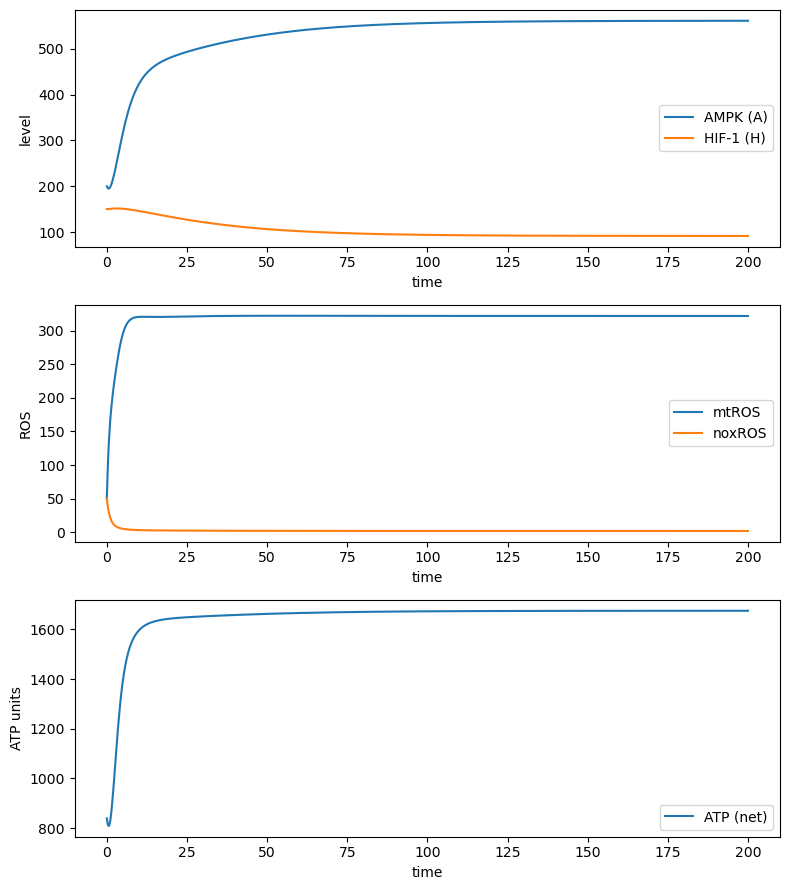

In [22]:
res = simulate(t_span=(0, 200))
print("Final A,H,ATP:", float(res['A'][-1]), float(res['H'][-1]), float(res['ATP'][-1]))

fig, ax = plt.subplots(3, 1, figsize=(8, 9))
ax[0].plot(res['t'], res['A'], label='AMPK (A)')
ax[0].plot(res['t'], res['H'], label='HIF-1 (H)')
ax[0].set_xlabel('time')
ax[0].set_ylabel('level')
ax[0].legend()

ax[1].plot(res['t'], res['Rmt'], label='mtROS')
ax[1].plot(res['t'], res['Rnox'], label='noxROS')
ax[1].set_xlabel('time')
ax[1].set_ylabel('ROS')
ax[1].legend()

ax[2].plot(res['t'], res['ATP'], label='ATP (net)')
ax[2].set_xlabel('time')
ax[2].set_ylabel('ATP units')
ax[2].legend()

plt.tight_layout()
plt.show()

## Helpers: evaluate f(A,H) = (dA/dt, dH/dt) using algebraic ROS/fluxes

In [23]:
def eqs_at(A, H, p):
    # Solve fluxes
    x,_ = solve_fluxes(A, H, p)
    G1,G2,F,Q1,Q3,G3,F2,Q2 = x
    ATP = atp_from_fluxes(x,p)
    # mtROS
    num_mt = p['gama1']*G1 + p['gamaf']*F + p['gQ1']*Q1
    den_mt = p['kr']*( Hs(A, p['Ar0_n'], p['nar_n'], p['Lamda_ar_n']) + 0.1*Hs(Q2, p['Q2R0'], p['nQ2R'], p['Lamda_Q2R']) )
    Rm = p['gr']*num_mt/den_mt
    # noxROS
    Rn = (p['gr_nox']/ (p['kr_nox']*Hs(Q2, p['Q2R0'], p['nQ2R'], p['Lamda_Q2R']))) * \
         Hcomp(p['g0'], p['g1'], p['g2'], H, p['hr0_nox'], p['nhr_nox'], A, p['Ar0_nox'], p['nar_nox'])
    R = Rm + Rn
    # dA/dt
    dA = p['ga']*Hs(R, p['Ra0'], p['nra'], p['Lamda_ra']) * Hs(H, p['ha0'], p['nha'], p['Lamda_ha']) * Hs(ATP, p['Aa0'], p['naa'], p['Lamda_aa']) - p['ka']*A
    # dH/dt
    dH = p['gh']*Hs(A, p['Ah0'], p['nah'], p['Lamda_ah']) - \
         p['kh']*H*Hs(R, p['Rh0'], p['nrh'], p['Lamda_rh']) * Hs(G2, p['G2h0'], p['nG2h'], p['Lamda_G2h']) * Hs(p['M'], p['Mh0'], p['nMh'], p['Lamda_Mh'])
    return dA, dH

## Grid evaluation and nullclines

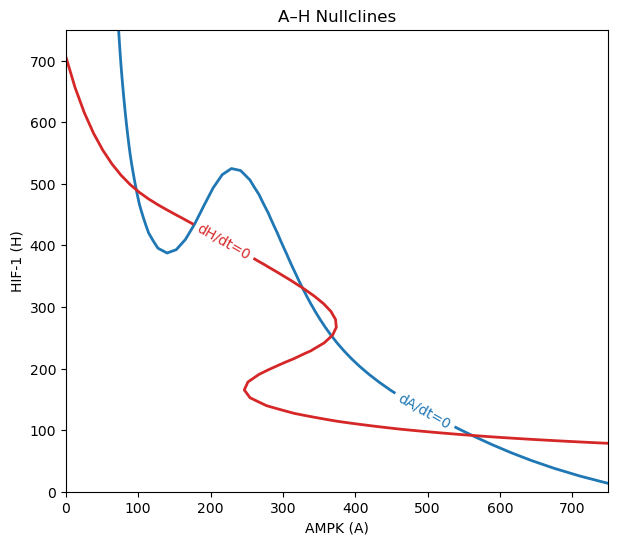

In [24]:
p = default_params()
r = 750.0
N = 60
A_vec = np.linspace(0, r, N)
H_vec = np.linspace(0, r, N)
EQ_A = np.zeros((N,N))
EQ_H = np.zeros((N,N))
for i, A in enumerate(A_vec):
    for j, H in enumerate(H_vec):
        dA, dH = eqs_at(A, H, p)
        EQ_A[j,i] = dA
        EQ_H[j,i] = dH

fig, ax = plt.subplots(1,1, figsize=(7,6))
CS1 = ax.contour(A_vec, H_vec, EQ_A, levels=[0], colors='C0', linewidths=2)
CS2 = ax.contour(A_vec, H_vec, EQ_H, levels=[0], colors='C3', linewidths=2)
ax.clabel(CS1, fmt={0:'dA/dt=0'}, inline=True)
ax.clabel(CS2, fmt={0:'dH/dt=0'}, inline=True)
ax.set_xlabel('AMPK (A)'); ax.set_ylabel('HIF-1 (H)'); ax.set_title('A–H Nullclines')
ax.set_xlim(0,r); ax.set_ylim(0,r)
plt.show()

## ATP curves

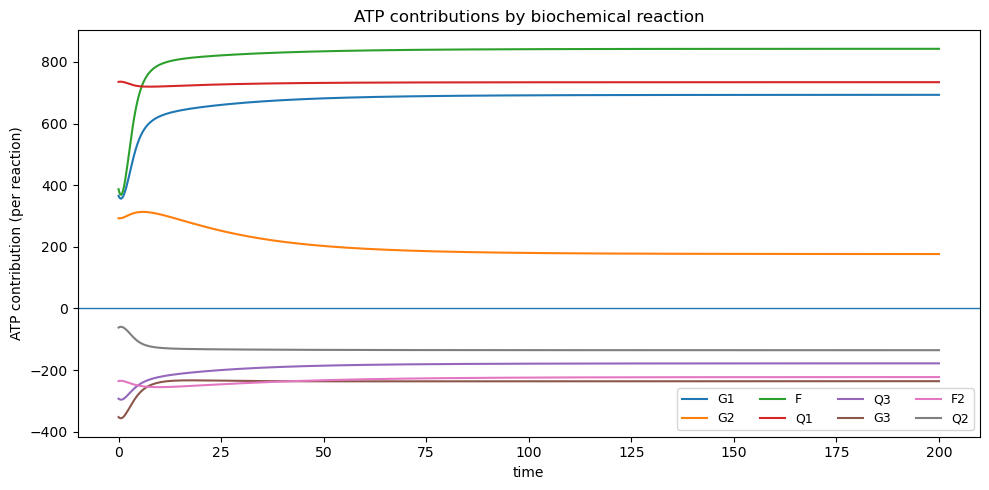

ATP producers: ['G1', 'G2', 'F', 'Q1']
ATP consumers: ['Q3', 'G3', 'F2', 'Q2']


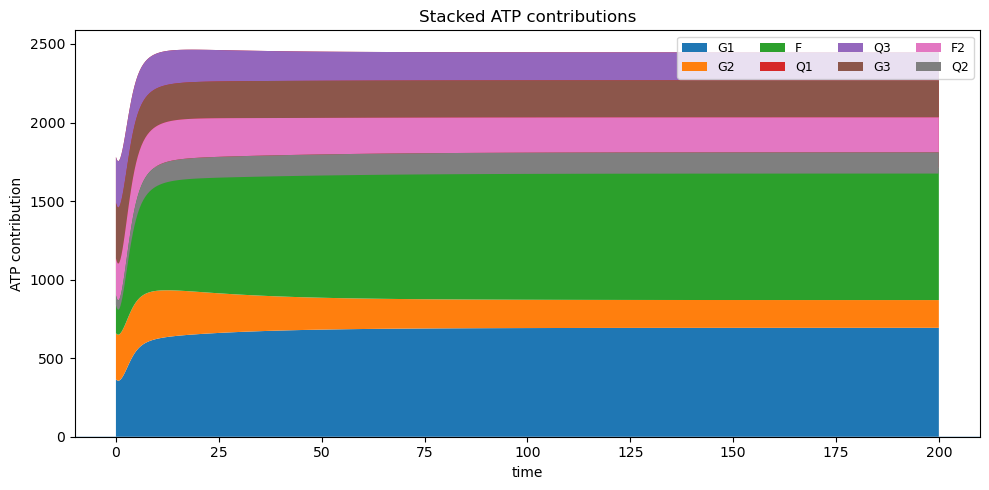

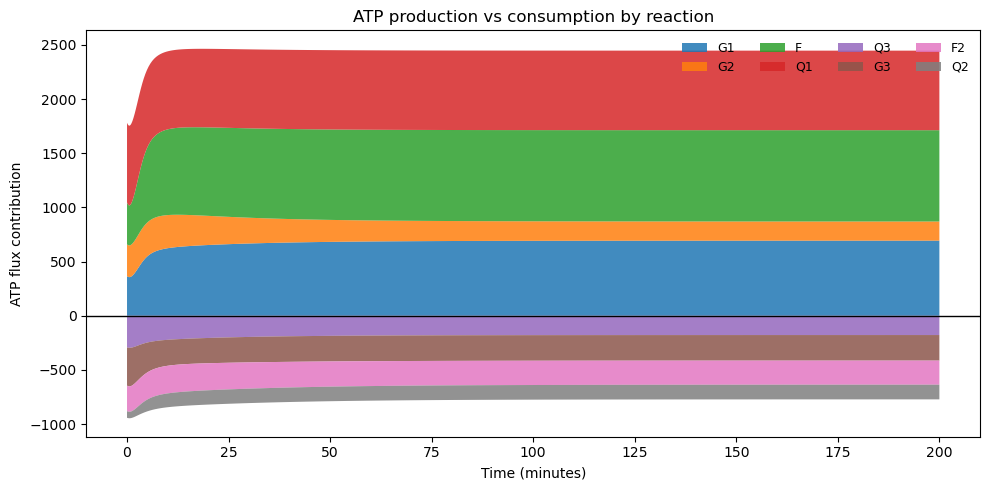

In [25]:

# Run (or reuse) simulation
#res = simulate(t_span=(0, 200))
# p   = default_params()

t = res["t"]



# --- ATP per reaction (same coefficients used in atp_from_fluxes) ---
atp_terms = {
    "G1": p["ATP_G1"] * res["G1"],
    "G2": p["ATP_G2"] * res["G2"],
    "F":  p["ATP_F"]  * res["F"],
    "Q1": p["ATP_Q1"] * res["Q1"],
    "Q3": p["ATP_Q3"] * res["Q3"],
    "G3": p["ATP_G3"] * res["G3"],
    "F2": p["ATP_F2"] * res["F2"],
    "Q2": p["ATP_Q2"] * res["Q2f"],  # note: your res key is "Q2f"
}

# 1) Line plot (each reaction’s ATP contribution vs time)
plt.figure(figsize=(10,5))
for k, v in atp_terms.items():
    plt.plot(t, v, label=k)
plt.axhline(0, linewidth=1)
plt.xlabel("time")
plt.ylabel("ATP contribution (per reaction)")
plt.title("ATP contributions by biochemical reaction")
plt.legend(ncol=4, fontsize=9)
plt.tight_layout()
plt.show()

# classify reactions by ATP usage
atp_producers = {k: v for k, v in atp_terms.items() if np.mean(v) > 0}
atp_consumers = {k: v for k, v in atp_terms.items() if np.mean(v) < 0}

print("ATP producers:", list(atp_producers.keys()))
print("ATP consumers:", list(atp_consumers.keys()))



# 2) Stacked area plot (helps see composition; negatives will stack downward)
labels = list(atp_terms.keys())
Y = np.vstack([atp_terms[k] for k in labels])

plt.figure(figsize=(10,5))
plt.stackplot(t, Y, labels=labels)
plt.axhline(0, linewidth=1)
plt.xlabel("time")
plt.ylabel("ATP contribution")
plt.title("Stacked ATP contributions")
plt.legend(ncol=4, fontsize=9, loc="upper right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

# ---- Producers (positive stack) ----
labels_pos = list(atp_producers.keys())
Y_pos = np.vstack([atp_producers[k] for k in labels_pos])

plt.stackplot(
    t,
    Y_pos,
    labels=labels_pos,
    alpha=0.85
)

# ---- Consumers (negative stack) ----
labels_neg = list(atp_consumers.keys())
Y_neg = np.vstack([atp_consumers[k] for k in labels_neg])

plt.stackplot(
    t,
    Y_neg,
    labels=labels_neg,
    alpha=0.85
)

# ---- Formatting ----
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Time (minutes)")
plt.ylabel("ATP flux contribution")
plt.title("ATP production vs consumption by reaction")

plt.legend(
    ncol=4,
    fontsize=9,
    loc="upper right",
    frameon=False
)

plt.tight_layout()
plt.show()


